# This code is to show modeling using two different methods CNN and RF.

Several aspects must be considered: 

1. Calling the data
2. Preparation of the CNN
3. Execution of the CNN and results on 20% of the data and 100% of the data.
4. Execution of the RF and results on 20% of the data and 100% of the data.
5. If you have problems downloading images, this code can be run without the 'PS_Index.tif' file. 
6. The file 'PS_Index_filtered.tif' is already in the repository, so you can avoid executing the download of point 5.
7. The reason why the file 'PS_Index.tif' is not in the repository is because the file weighs more than 20MB (in this case 1.2 GB). 
8. But you can download It using the link in the file 'PS_index.txt' in folder 'DataIntermediate'.
Index

### 1. Prepare and call the data
### 2. Run CNN-1D for predict soil saliniy with SAR
### 3. Run a RF model for predict soil saliniy with SAR
### 4. The models show that RF is better for prediction, so in this case we will apply this model to the raster data

## 1. Prepare and call the data

In [1]:
import pandas as pd

data = pd.read_csv('../DataIntermediate/merged_data_cafine.csv', sep = ',')
data.rename(columns={
    'b1_1': 'Clay+Silt Raster',
    'b2_1': 'Sand Raster',
    'b3_1': 'Silt Raster',
    'b4_1': 'Clay Raster',
    'Unnamed: 0': 'Id'
}, inplace=True)

data.head()

,Id,NDVI,SR,GCVI,NDWI,VARI,GNDVI,GRVI,SAVI,VSSI,...,YNSI2_G2,YNInt2_G1,YNInt2_G2,YNNDSI,YNNDVI,Clay+Silt Raster,Sand Raster,Silt Raster,Clay Raster,SAR
0,0,0.364127,2.145283,2.336546,-0.538803,-0.330611,0.538803,3.336546,0.242722,-19060.0,...,2029.7554,1708.75,1740.25,0.031445,-0.031445,0.000000,0.000000,0.000000,0.000000,26.926614
1,1,0.439585,2.568796,2.107235,-0.513050,-0.154374,0.513050,3.107235,0.293014,-15495.0,...,1662.3491,1401.75,1432.25,-0.059287,0.059287,0.519413,0.473399,0.337390,0.181547,86.327645
2,2,0.508677,3.070660,2.571547,-0.562505,-0.128842,0.562505,3.571547,0.339072,-16807.0,...,1604.8911,1356.50,1383.25,-0.074180,0.074180,0.654887,0.343329,0.461192,0.192468,112.754286
3,3,0.416839,2.429589,1.797036,-0.473273,-0.125389,0.473273,2.797036,0.277851,-15069.5,...,1722.4656,1465.75,1484.50,-0.059602,0.059602,0.524789,0.470715,0.431571,0.093336,193.130080
4,4,0.354755,2.100475,1.346602,-0.402379,-0.109266,0.402379,2.346602,0.236459,-11940.0,...,1522.3079,1291.25,1314.25,-0.048999,0.048999,0.517817,0.474641,0.407218,0.110598,126.060248


In [2]:
# Select from data the index selected

data_for_model = data[['Id','YNNDSI', 'Clay Raster','YBS2','RS5_G2','YNNDVI','SAR']]

data_for_model.head()

,Id,YNNDSI,Clay Raster,YBS2,RS5_G2,YNNDVI,SAR
0,0,0.031445,0.000000,-0.031445,1253.3464,-0.031445,26.926614
1,1,-0.059287,0.181547,0.059287,1085.8315,0.059287,86.327645
2,2,-0.074180,0.192468,0.074180,1095.6101,0.074180,112.754286
3,3,-0.059602,0.093336,0.059602,1043.8142,0.059602,193.130080
4,4,-0.048999,0.110598,0.048999,912.2394,0.048999,126.060248


In [3]:
X = data_for_model[['YNNDSI', 'Clay Raster','YBS2','RS5_G2']]
y = data_for_model[['SAR']]

## 2. Run CNN-1D for predict soil salinity with SAR

Epoch [10/50], Train Loss: 30.50721291319965, Test Loss: 28.38691670185811
Epoch [20/50], Train Loss: 28.363765559784355, Test Loss: 28.852225844924515
Epoch [30/50], Train Loss: 24.086903088713346, Test Loss: 27.362297986004805
Epoch [40/50], Train Loss: 25.383642301167527, Test Loss: 31.056858475143844
Epoch [50/50], Train Loss: 24.645092585315442, Test Loss: 27.70349002528835


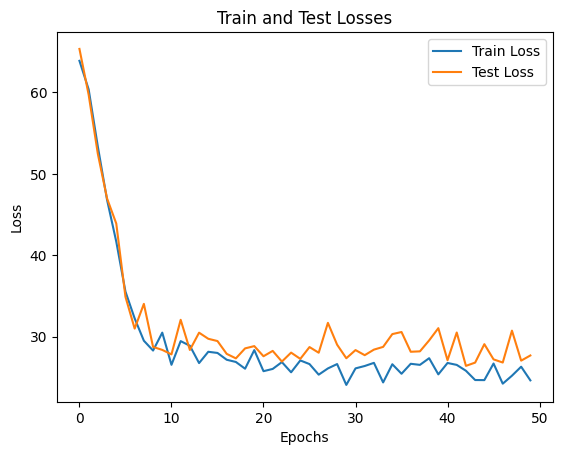

In [23]:
#@title CNN Cov-1D

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

lista = ['YNNDSI', 'Clay Raster','YBS2','RS5_G2']

count = len(lista)

# Define model parameters
input_size = count  # Number of features
hidden_size = 32 # Si lo pongo por encima de 80 me afecta demasiado la variación de la FLoss
batch_size = 32
num_epochs = 50
learning_rate = 0.1 # Valores más bajos no funcionan.
regularization_param = 0.1
dropout_p = 0.01

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.flatten(), dtype=torch.float32)  # Convert to a 1D tensor
y_test_tensor = torch.tensor(y_test.values.flatten(), dtype=torch.float32)

# Create datasets and dataloaders
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=hidden_size, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc2 = nn.Linear(hidden_size * 1, hidden_size)  # The size of the convolution output is 4
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.bn4 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(p=dropout_p)
        self.fc5 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.conv1(x.unsqueeze(1))  # Add channel dimension
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)  # Flatten the convolution output
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = nn.functional.relu(x)
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.dropout(x)
        x = self.fc5(x)
        return x

# Initialize the model
model = CNN()

# Define the loss function and optimizer
loss_fn = nn.SmoothL1Loss()  # Regression loss * MSELoss funciona pero no mucho. 
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=regularization_param)  # Adagrad, RMSprop (los dos que me dieron mejor)

# Train the model
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_dl:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels.unsqueeze(1))  # Add output dimension
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_dl.dataset)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_dl:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.unsqueeze(1))  # Add output dimension
            test_loss += loss.item() * inputs.size(0)
    test_loss /= len(test_dl.dataset)
    test_losses.append(test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss}, Test Loss: {test_loss}')

# Plot losses
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()
plt.show()


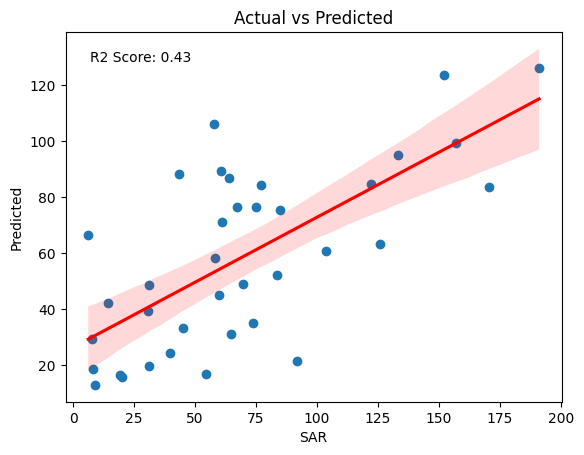

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Function to obtain model predictions
def get_predictions(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            outputs = model(inputs)
            predictions.extend(outputs.tolist())
    return predictions

# Obtain the model predictions on the test set
y_pred = get_predictions(model, test_dl)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

# Plotting the scatter plot
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted")

# Adding the regression line
sns.regplot(x=y_test, y=y_pred, scatter=False, ax=ax, color='red')

# Adding the R2 score as annotation
ax.annotate(f'R2 Score: {r2:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')

plt.show()

In [6]:
# Obtener el summary del modelo
from torchsummary import summary
import numpy as np

summary(model, input_size=(4,))  # input_size debe ser el tamaño de la entrada de tus datos

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 32, 2]             128
       BatchNorm1d-2                [-1, 32, 2]              64
         MaxPool1d-3                [-1, 32, 1]               0
            Linear-4                   [-1, 32]           1,056
       BatchNorm1d-5                   [-1, 32]              64
            Linear-6                   [-1, 32]           1,056
       BatchNorm1d-7                   [-1, 32]              64
            Linear-8                   [-1, 32]           1,056
       BatchNorm1d-9                   [-1, 32]              64
          Dropout-10                   [-1, 32]               0
           Linear-11                    [-1, 1]              33
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

In [7]:
# Guardar el estado del modelo
#torch.save(model.state_dict(), '../Results/model.pth')

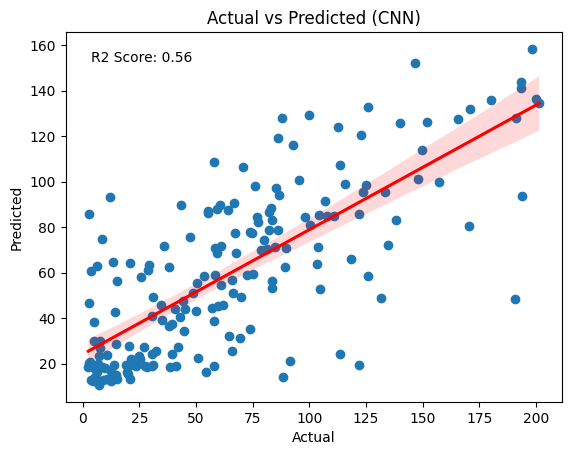

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import numpy as np

X_t = pd.DataFrame(X, columns= lista).dropna()
y_t = pd.DataFrame(y[["SAR"]]).dropna()

# Scale X1 features
X_t_scaled = scaler.fit_transform(X_t)

# Convert to PyTorch tensors
X1_tensor = torch.tensor(X_t_scaled, dtype=torch.float32)
y1_tensor = torch.tensor(y_t.values.flatten(), dtype=torch.float32)  # Convert to a 1D tensor

# Create a DataLoader for X1 and y1 data
data_tensor = TensorDataset(X1_tensor, y1_tensor)
data_loader = DataLoader(data_tensor, batch_size=batch_size)

# Get model predictions on X1 data
y_pred_all_cnn = get_predictions(model, data_loader)

y1_tensor = y1_tensor.numpy()

all_predicted = np.array(y_pred_all_cnn)

# Calculate R2 score
r2_all_cnn = r2_score(y1_tensor, all_predicted)

# Plotting the scatter plot
fig, ax = plt.subplots()
ax.scatter(y1_tensor, y_pred_all_cnn)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted (CNN)")

# Add the regression line
sns.regplot(x=y1_tensor, y=y_pred_all_cnn, scatter=False, ax=ax, color='red')

# Add the coefficient of determination (R2) as an annotation
ax.annotate(f'R2 Score: {r2_all_cnn:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')

plt.show()


## 3. Run a RF model for predict soil saliniy with SAR

C:\Users\cespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test set Pearson correlation: 0.805230668219909


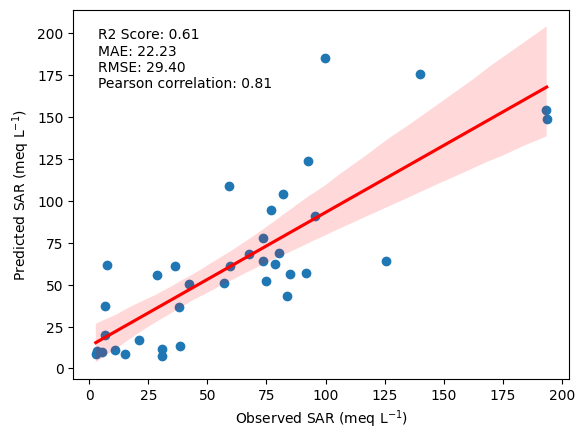

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
from joblib import dump
import pandas as pd


# split the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=65)
# Scale the train & test data set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Function to fit the RandomForestRegressor model
def fit_rf(X_train, y_train):
    # Initialize and fit the RandomForestRegressor model
    model = RandomForestRegressor(n_estimators=100, criterion='squared_error', min_samples_split=2, random_state=42)
    model.fit(X_train, y_train.values.ravel())
    # Save the model
    save_path = '../Results/random_forest_model.joblib'
    dump(model, save_path)

    return model

# Function to predict and evaluate the model on a dataset
def predict_and_evaluate(model, X, y_true):
    y_pred = model.predict(X)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    pearson_corr, _ = pearsonr(y_true.values.ravel(), y_pred)
    return y_pred, r2, mae, rmse, pearson_corr

# Function to visualize the results
def plot_results(y_true, y_pred, title, r2, mae, rmse, pearson_corr):
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred)
    # Add the regression line
    sns.regplot(x=y_true, y=y_pred, scatter=False, ax=ax, color='red')
    ax.set_ylabel('Predicted SAR (meq L$^{-1}$)')
    ax.set_title(title)
    ax.set_xlabel('Observed SAR (meq L$^{-1}$)')

    # Add metrics as annotations
    ax.annotate(f'R2 Score: {r2:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nPearson correlation: {pearson_corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')

    plt.show()

# Save the scaler
scaler_path = '../Results/scaler.joblib'
dump(scaler, scaler_path)

# Fit the RandomForestRegressor model
rf_model = fit_rf(X_train, y_train)

# Evaluate on the test set 
y_pred_test, r2_test, mae_test, rmse_test, pearson_corr_test = predict_and_evaluate(rf_model, X_test, y_test)

mean_y_test = np.mean(y_test)

print('Test set Pearson correlation:', pearson_corr_test)
plot_results(y_test, y_pred_test, "", r2_test, mae_test, rmse_test,  pearson_corr_test)


C:\Users\cespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


All data Pearson correlation: 0.9301727304119898
MAE on all data: 13.919674882588946
RMSE on all data: 19.185322837852052


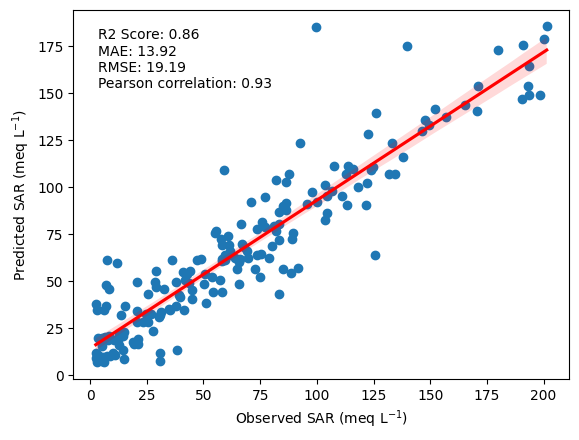

MAE on all data: 13.919674882588946
RMSE on all data: 19.185322837852052


In [15]:
# Evaluate on the entire dataset

X_scaled = scaler.transform(X)  # Scale the entire dataset
y_pred_all, r2_all, mae_all, rmse_all, pearson_corr_all = predict_and_evaluate(rf_model, X_scaled, y)
print('All data Pearson correlation:', pearson_corr_all)
print('MAE on all data:', mae_all)
print('RMSE on all data:', rmse_all)
plot_results(y, y_pred_all, "", r2_all, mae_all, rmse_all, pearson_corr_all)

# Print metrics
print('MAE on all data:', mae_all)
print('RMSE on all data:', rmse_all)

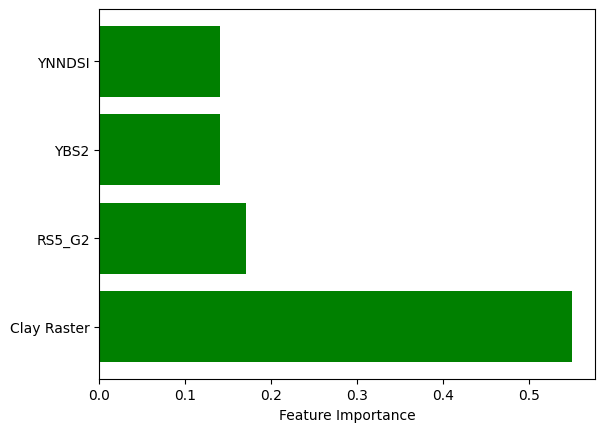

In [10]:
# Obtener las importancias de características
importance_values = rf_model.feature_importances_
importance_names = X.columns

# Create a list of tuples with feature names and their importances
importance_pairs = list(zip(importance_names, importance_values))

# Sort the list of tuples in descending order based on the importance
importance_pairs = sorted(importance_pairs, key=lambda x: x[1], reverse=True)

importance_data_frame = pd.DataFrame(importance_pairs, columns=['Feature', 'Importance'])

# Plot the sorted list of tuples
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Unzip the sorted list of tuples and plot the feature names and importances
for feature_name, importance in importance_pairs:
    ax.barh(feature_name, importance, color='green')

plt.xlabel("Feature Importance")
plt.title("")
plt.show()

## 4. The models show that RF is better for prediction, so in this case we will apply this model to the raster data

In [13]:
import rasterio
import numpy as np
import os.path as op
import joblib

# Input image
planet_image = '../DataIntermediate/PS_Index_filtered.tif'

# Especify the output image
output_image = op.join('../Results/', "SAR_Modeled.tif")

with rasterio.open(planet_image, 'r') as src:
    profile = src.profile
    profile.update(
        dtype=rasterio.float32,
        count=1,
    )
    with rasterio.open(output_image, 'w', **profile) as dst:
        # Read the image
        data = src.read()

        # Preparing the image for prediction
        img_swp = np.moveaxis(data, 0, 2)
        img_flat = img_swp.reshape(-1, img_swp.shape[-1])

        # Delete invalid values, store indexes for later use 
        m = np.ma.masked_invalid(img_flat)
        valid_pixels = img_flat[~m.mask.any(axis=1)]
        rf_model_path = '../Results/random_forest_model.joblib'
        scaler_path = '../Results/scaler.joblib'  # Rout scaler

        rf_model_raster = joblib.load(rf_model_path)
        scaler = joblib.load(scaler_path)  # Charge the scaler if it was used during training.
        
        # Skip empty entries
        if len(valid_pixels):
            # Scale valid pixels data if scaler was used during training.
            valid_pixels_scaled = scaler.transform(valid_pixels)

            # Predict
            img_preds = rf_model_raster.predict(valid_pixels_scaled)
            print(img_preds)

            # Add the prediction back to the valid pixels
            output = np.zeros(img_flat.shape[0], dtype=np.float32)
            output[~m.mask.any(axis=1)] = img_preds.flatten()

            # Resize to the original image dimensions
            output = output.reshape(*img_swp.shape[:-1])

            # Create the final mask
            mask = (~m.mask.any(axis=1)).reshape(*img_swp.shape[:-1])

            # Write to final files
            dst.write(output.astype(rasterio.float32), 1)
            dst.write_mask(mask)



C:\Users\cespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[42.54145676 64.52095585 44.20577304 ... 85.25959307 80.87838342
 80.67399947]


Coefficient of determination (R^2): 0.5909933870844652
Pearson Correlation: 0.7696824078820932
Mean Absolute Error (MAE): 23.767448762226746
Root Mean Squared Error (RMSE): 32.6135257215354


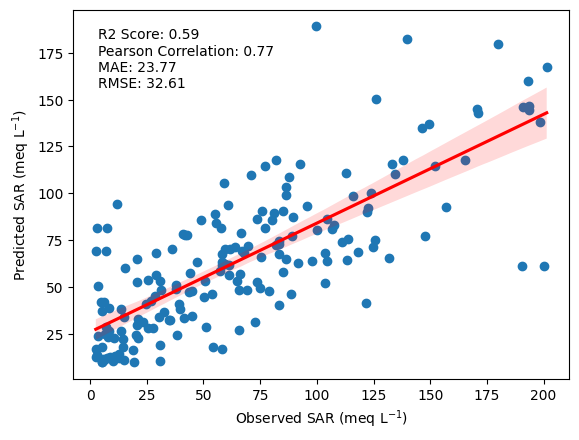

In [13]:
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.mask import mask
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Path to the GeoJSON file
geojson_file = '../DataIn/Salinity_data.geojson'

# Load the GeoJSON file with geopandas
points = gpd.read_file(geojson_file)

# Path to the raster file
raster_file = '../Results/SAR_Modeled.tif'

# Initialize lists to store observed and predicted values
observed_values = []
predicted_values = []

# Open the raster file
with rasterio.open(raster_file) as src:
    for point in points.geometry:
        # Extract observed values from GeoJSON (SAR column)
        observed_value = points[points.geometry == point]['SAR'].iloc[0]
        observed_values.append(observed_value)
        
        # Extract predicted values from the raster at the point location
        try:
            geoms = [point.__geo_interface__]
            out_image, out_transform = mask(src, geoms, crop=True)
            
            # Check if the cropped region is empty
            if np.isnan(out_image).all():
                raise ValueError("The point is outside the raster bounds or contains invalid values.")
            
            # Extract the predicted value
            predicted_value = out_image[0].mean()  # Average in case of multiple values within the crop
            predicted_values.append(predicted_value)
        except Exception as e:
            print(f"Failed to extract the value for the point: {e}")
            observed_values.pop()  # Remove the corresponding observed value if prediction fails

# Convert lists to numpy arrays
observed_values = np.array(observed_values)
predicted_values = np.array(predicted_values)

# Calculate metrics
r_squared = r2_score(observed_values, predicted_values)
pearson_corr = np.corrcoef(observed_values, predicted_values)[0, 1]
mae = mean_absolute_error(observed_values, predicted_values)
rmse = np.sqrt(mean_squared_error(observed_values, predicted_values))

print("Coefficient of determination (R^2):", r_squared)
print("Pearson Correlation:", pearson_corr)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

# Plotting the scatter plot
fig, ax = plt.subplots()
ax.scatter(observed_values, predicted_values)
ax.set_ylabel('Predicted SAR (meq L$^{-1}$)')
ax.set_xlabel('Observed SAR (meq L$^{-1}$)')
ax.set_title("")

# Adding the regression line
sns.regplot(x=observed_values, y=predicted_values, scatter=False, ax=ax, color='red')

# Adding the R2 score, Pearson correlation, MAE, and RMSE as annotations
ax.annotate(f'R2 Score: {r_squared:.2f}\nPearson Correlation: {pearson_corr:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}',
            xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')

plt.show()



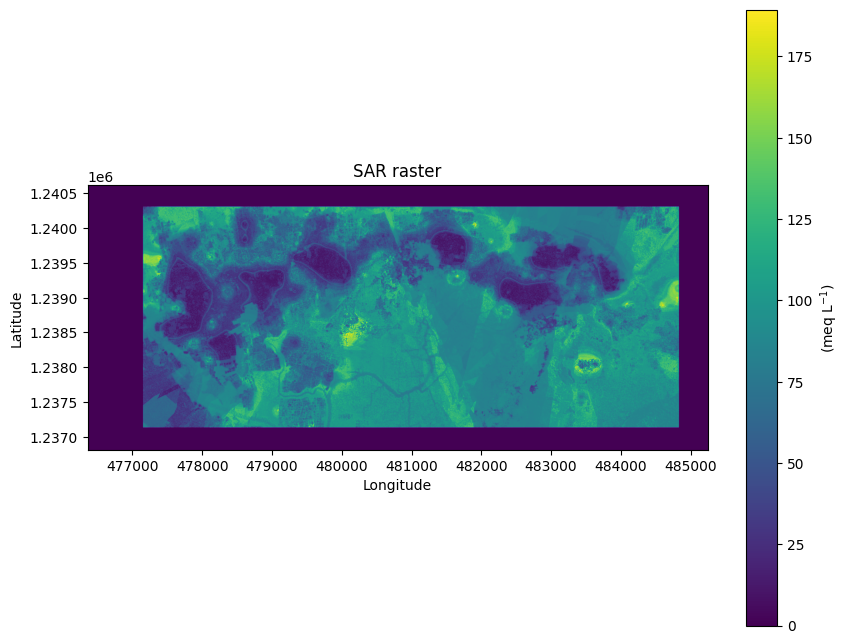

In [15]:
import rasterio.plot

# Open the output raster file for visualization
with rasterio.open(output_image, 'r') as src:
    # Read the raster data
    raster_data = src.read(1)  # Read the first band, assuming there's only one band

    # Get the spatial extent of the raster
    extent = rasterio.plot.plotting_extent(src)

    # Plot the raster with symbology and create the color bar
    plt.figure(figsize=(10, 8))
    img_plot = plt.imshow(raster_data, extent=extent, cmap='viridis')
    plt.title('SAR raster')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar(img_plot, label='(meq L$^{-1}$)')  # Use the img_plot object to create the color bar
    plt.show()

